<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Predict_Serie_Analys%C3%A9e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

# Analyse de la série

**1. Visualisation de la série et tests ACF & PACF**

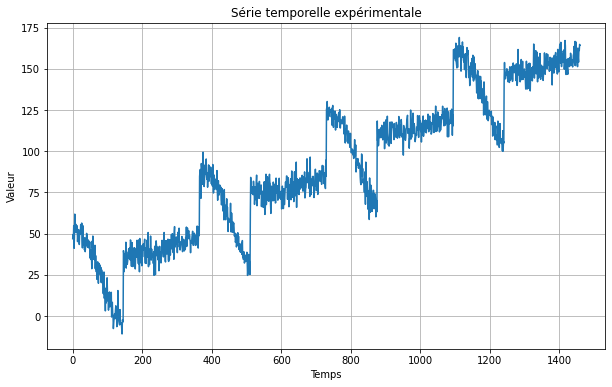

In [3]:
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Autocorrélation partielle de la série Homoscédatique')

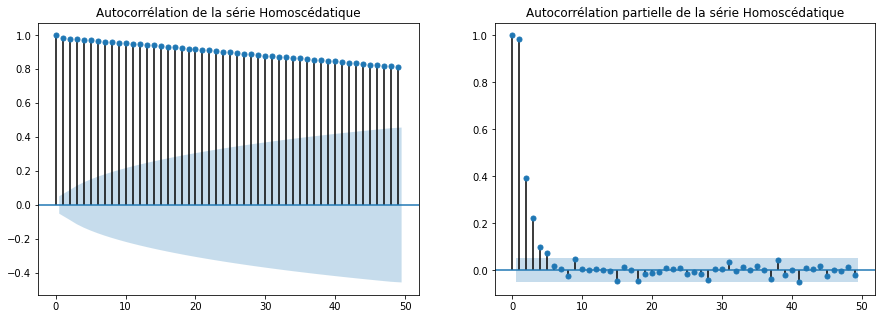

In [4]:
# ACF & PACF de la série Homoscédatique

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(serie, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la série Homoscédatique")

plot_pacf(serie, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la série Homoscédatique")

**2. Extraction de la tendance**

Text(0.5, 1.0, 'Série avec tendance non linéaire supprimée')

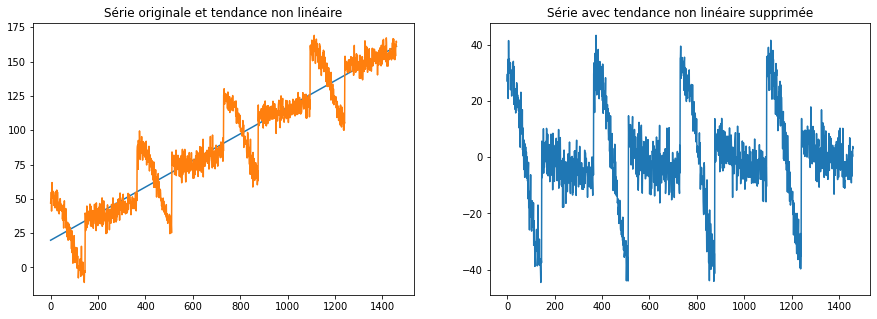

In [5]:
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Calcul des coefficients
x = np.linspace(0,len(serie),len(serie))
coefs = np.polyfit(x,serie,1)

# Calcul de la tendance non linéaire
trend = coefs[0]*np.power(x,1) + coefs[1]

# Calcul de la série sans tendance
serie_detrend = serie - trend

# Affiche les résultats
ax1.plot(trend)
ax1.plot(serie)
ax1.set_title("Série originale et tendance non linéaire")

ax2.plot(serie_detrend)
ax2.set_title("Série avec tendance non linéaire supprimée")

**3. Normalisation des valeurs**

In [6]:
# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(serie_detrend)
std = tf.math.reduce_std(serie_detrend)

# Normalise les données
Serie_Normalisee = (serie_detrend-mean)/std
min = tf.math.reduce_min(serie_detrend)
max = tf.math.reduce_max(serie_detrend)

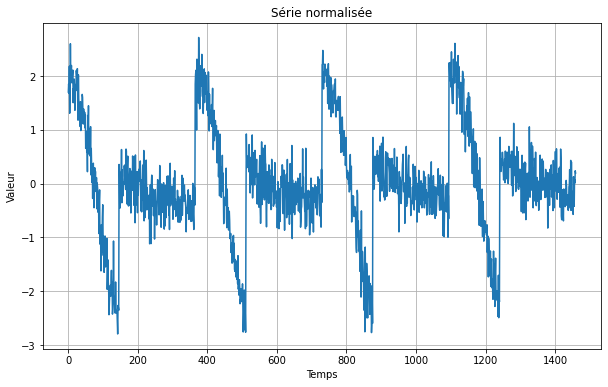

In [7]:
plt.figure(figsize=(10, 6))
affiche_serie(temps,Serie_Normalisee)
plt.title('Série normalisée')
plt.show()

Text(0.5, 1.0, 'Autocorrélation partielle de la série normalisée sans tendance')

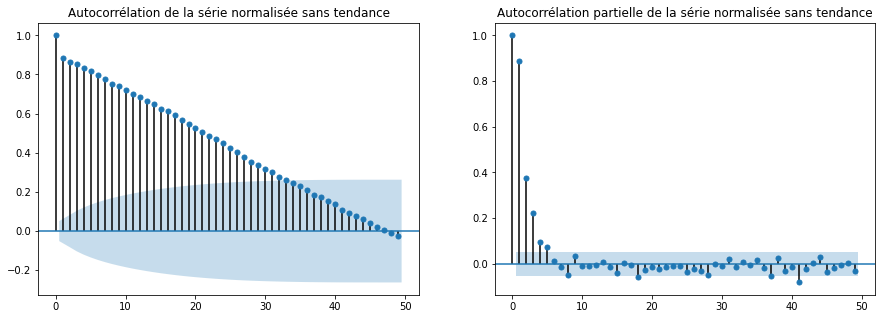

In [8]:
# ACF & PACF de la série

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(Serie_Normalisee, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la série normalisée sans tendance")

plot_pacf(Serie_Normalisee, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la série normalisée sans tendance")

In [9]:
import statsmodels.api as sm

serie_test = Serie_Normalisee

adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(serie_test)

adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -4.164102561957332
p-value: 0.0007574090128337717,
N: 1455, 
critical values: {'1%': -3.4348523191002123, '5%': -2.8635284734563364, '10%': -2.567828646449617}


# Création des données normalisées pour l'entrainement et le test

In [10]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

In [11]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 5
batch_size = 32
buffer_melange = 1000

temps_separation = 1000

# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

# Modèle RNN simple

**1. Création du réseau récurrent**

Notre réseau maintenant le suivant :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/ModifGene_2.png?raw=true" width="1200"> 

In [28]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()
model.load_weights("model_initial.hdf5")

In [13]:
# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
s_encodeur = tf.keras.layers.SimpleRNN(40,kernel_regularizer=tf.keras.regularizers.l2(1e-5))(e_adapt)

# Décodeur
s_decodeur = tf.keras.layers.Dense(40,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 5, 1)         0           input_1[0][0]                    
__________________________________________________________________________________________________
simple_rnn (SimpleRNN)          (None, 40)           1680        lambda[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 40)           1640        simple_rnn[0][0]                 
______________________________________________________________________________________________

**4. Entrainement du modèle avec l'optimiseur SGD**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*20**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle en utilisant la méthode ModelCheckpoint pour sauvegarder les meilleurs poids du modèle
historique = model.fit(dataset_norm, epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

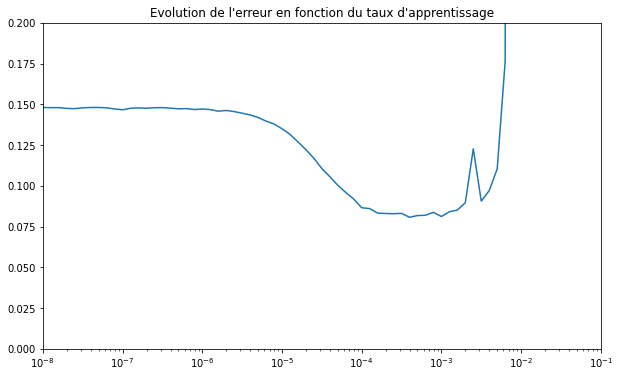

In [15]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ 1e-8, 1e-1, 0, 0.2])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [16]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [ ]:
from timeit import default_timer as timer

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=4e-4,
    decay_steps=10,
    decay_rate=0.1
    )


# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint])

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

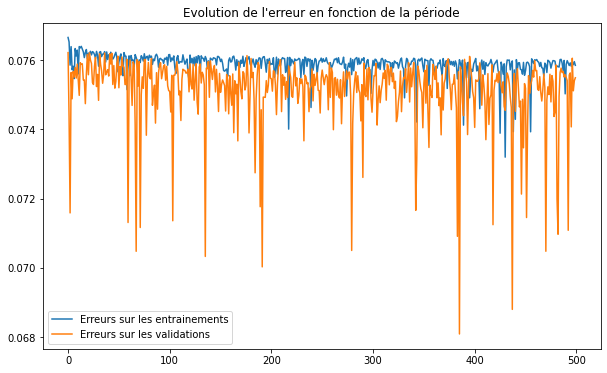

In [19]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

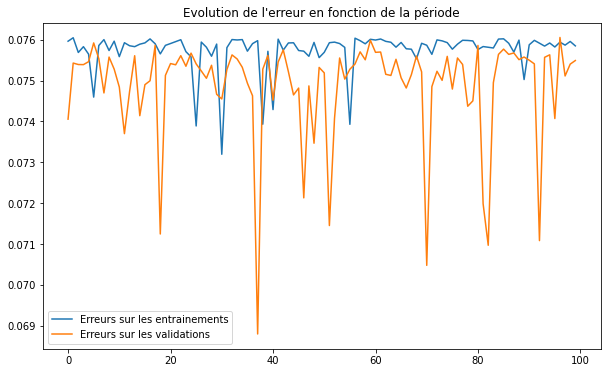

In [20]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**5. Prédiction des données**

In [21]:
# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

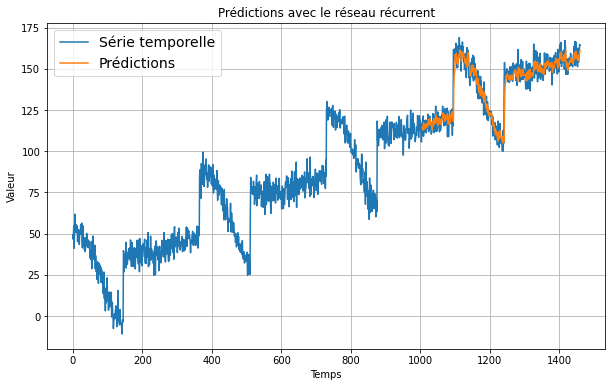

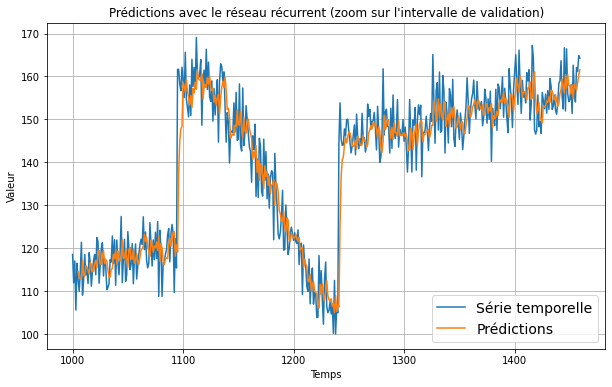

In [26]:
preds = np.asarray((predictions*std+mean))[:,0,0] + trend[temps_separation+taille_fenetre:]

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],preds,label="Prédictions")
plt.title('Prédictions avec le réseau récurrent')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],preds,label="Prédictions")
plt.title("Prédictions avec le réseau récurrent (zoom sur l'intervalle de validation)")
plt.show()

**6. Analyse des résultats**

In [28]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],preds).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],preds).numpy()

print(mae)
print(mse)

4.748660900246631
41.22097708521502


Text(0.5, 1.0, 'Autocorrélation partielle de la série Homoscédatique')

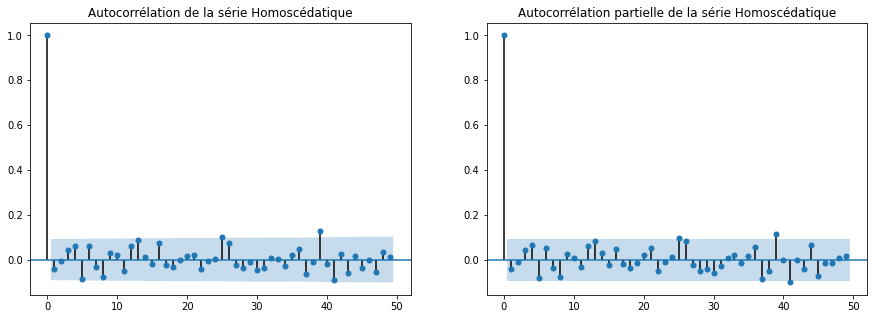

In [30]:
residus = serie[temps_separation+taille_fenetre:] - preds

# ACF & PACF de la série Homoscédatique

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(residus, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la série Homoscédatique")

plot_pacf(residus, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la série Homoscédatique")

# Modèle GRU + Auto-attention

**1. Création du réseau récurrent**

In [12]:
# Classe d'auto-attention
# Applique les poids de la matrice d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Auto_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att,nbr_hop):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    self.nbr_hop = nbr_hop
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer='glorot_uniform',name="W")
    self.U = self.add_weight(shape=(self.nbr_hop,self.dim_att),initializer='glorot_uniform',name="U")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    xt = tf.transpose(x,perm=[0,2,1])           # (None,20,40) => (None,40,20)
    Xh = tf.matmul(self.W,xt)                   # (#Att,40)x(None,40,20) = (None,#Att,20)
    Xh = K.tanh(Xh)                             # Xh = (None,#Att,20)

    # Calcul de la matrice des poids d'attention normalisés
    A = tf.matmul(self.U,Xh)                    # (#hop,#Att)x(None,#Att,20) = (None,#Att,20)
    A = tf.keras.activations.softmax(A,axis=2)  # (None,#Att,20)

    # Calcul de la matrice des vecteur d'attentions
    sortie = tf.matmul(A,x)                     # (None,#Att,20)x(None,20,40) = (None,#Att,40)
    return tf.keras.layers.Flatten()(sortie)

In [13]:
dim_GRU = 40
nbr_hop = 3

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition de l'entrée du modèle
entrees = tf.keras.layers.Input(shape=(taille_fenetre))

# Encodeur
e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
s_encodeur = tf.keras.layers.GRU(dim_GRU,return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(1e-5))(e_adapt)
s_attention = Couche_Auto_Attention(dim_att=dim_GRU,nbr_hop=nbr_hop)(s_encodeur)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_GRU*nbr_hop,activation="tanh")(s_attention)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_attention])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model(entrees,sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 5, 1)         0           input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (None, 5, 40)        5160        lambda[0][0]                     
__________________________________________________________________________________________________
couche__auto__attention (Couche (None, 120)          1720        gru[0][0]                        
______________________________________________________________________________________________

**4. Entrainement du modèle avec l'optimiseur Adam**

In [14]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
31/31 [==============================] - 2s 5ms/step - loss: 0.4481 - mae: 0.7871

Epoch 00001: loss improved from inf to 0.43908, saving model to poids.hdf5
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4199 - mae: 0.7491

Epoch 00002: loss did not improve from 0.43908
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4331 - mae: 0.7629

Epoch 00003: loss did not improve from 0.43908
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4430 - mae: 0.7806

Epoch 00004: loss did not improve from 0.43908
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4563 - mae: 0.7889

Epoch 00005: loss did not improve from 0.43908
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4416 - mae: 0.7715

Epoch 00006: loss did not improve from 0.43908
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 0.4362 - mae: 0.7726

Epoch 00007: loss did not

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

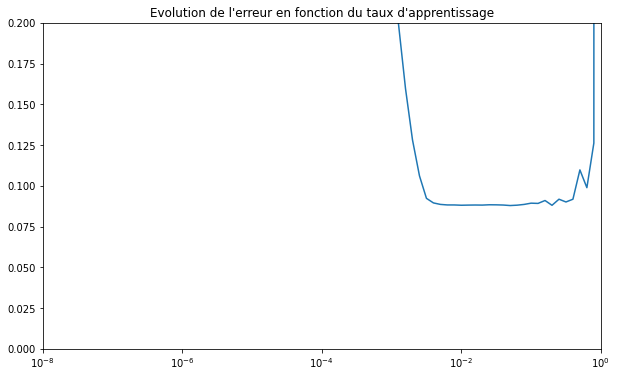

In [16]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ 1e-8, 1, 0, 0.2])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [17]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [18]:
# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,StopTrain(delta=5e-5,periodes = 20, term="loss")])

Epoch 1/500
31/31 [==============================] - 3s 36ms/step - loss: 0.0995 - mae: 0.3208 - val_loss: 0.0850 - val_mae: 0.3097

Epoch 00001: loss improved from inf to 0.08976, saving model to poids_train.hdf5
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 0.0820 - mae: 0.3024 - val_loss: 0.0818 - val_mae: 0.3064

Epoch 00002: loss improved from 0.08976 to 0.08782, saving model to poids_train.hdf5
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 0.0931 - mae: 0.3183 - val_loss: 0.0800 - val_mae: 0.3012

Epoch 00003: loss did not improve from 0.08782
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 0.0831 - mae: 0.3075 - val_loss: 0.0799 - val_mae: 0.3026

Epoch 00004: loss improved from 0.08782 to 0.08757, saving model to poids_train.hdf5
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 0.0917 - mae: 0.3211 - val_loss: 0.0786 - val_mae: 0.3018

Epoch 00005: loss improved from 0.08757 t

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

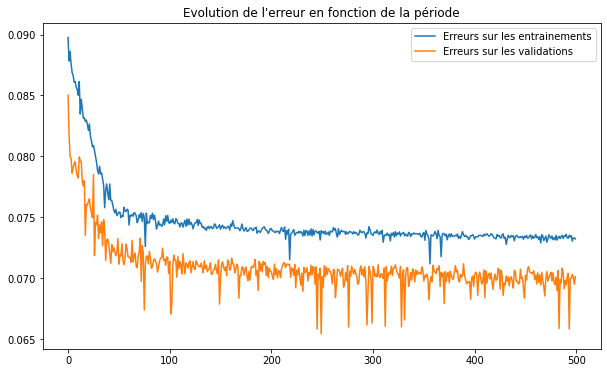

In [19]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

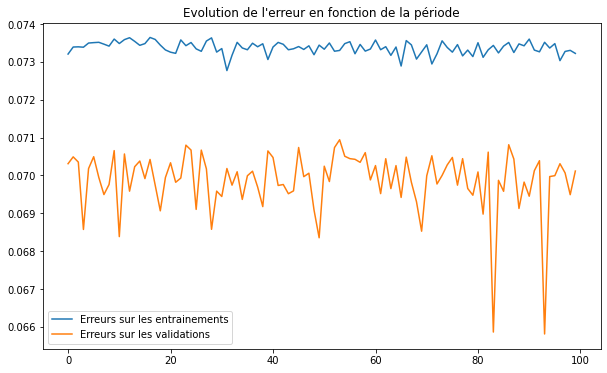

In [20]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**5. Prédiction des données**

In [21]:
# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(Serie_Normalisee[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

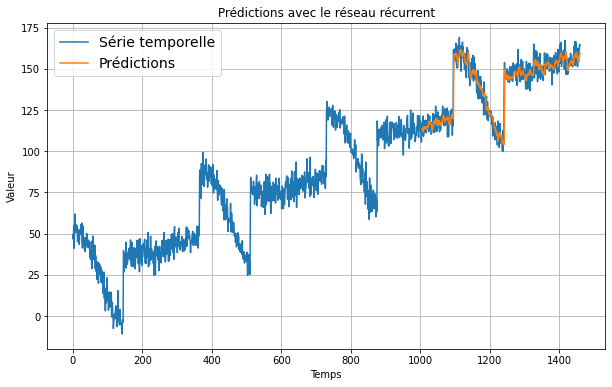

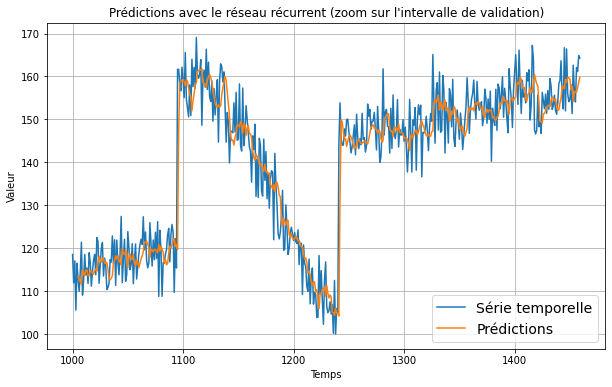

In [22]:
preds = np.asarray((predictions*std+mean))[:,0,0] + trend[temps_separation+taille_fenetre:]

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],preds,label="Prédictions")
plt.title('Prédictions avec le réseau récurrent')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],preds,label="Prédictions")
plt.title("Prédictions avec le réseau récurrent (zoom sur l'intervalle de validation)")
plt.show()

**6. Analyse des résultats**

In [23]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],preds).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],preds).numpy()

print(mae)
print(mse)

4.5631320045667865
38.121599817865516


Text(0.5, 1.0, 'Autocorrélation partielle de la série Homoscédatique')

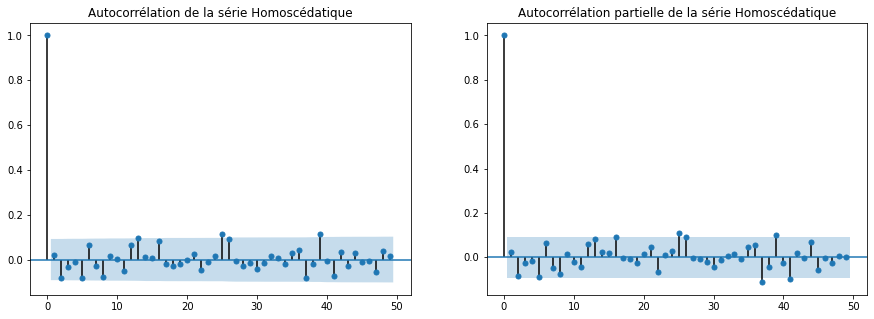

In [24]:
residus = serie[temps_separation+taille_fenetre:] - preds

# ACF & PACF de la série Homoscédatique

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(residus, ax=ax1, lags = range(0,50))
ax1.set_title("Autocorrélation de la série Homoscédatique")

plot_pacf(residus, ax=ax2, lags = range(0, 50))
ax2.set_title("Autocorrélation partielle de la série Homoscédatique")

# Modèle End-to-End memory Network

**1. Création du réseau récurrent**

In [12]:
def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange,nbr_sequences):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.window(nbr_sequences+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(nbr_sequences+1,drop_remainder=True))
  dataset = dataset.map(lambda x: [(tf.slice(x,[0,0],[nbr_sequences,taille_fenetre]),                           # (30;20)       [((30,20),(20)),(1)]
                                   tf.squeeze(tf.slice(x,[nbr_sequences,0],[1,taille_fenetre]),axis=0)),        # (20)
                                   tf.squeeze(tf.slice(x,[nbr_sequences,taille_fenetre],[1,1]),axis=0)])        # (1)
  dataset = dataset.batch(batch_size,drop_remainder=True)
  return dataset


temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = Serie_Normalisee[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = Serie_Normalisee[temps_separation:]


# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 5
batch_size = 32
buffer_melange = 1000
Nbr_Sequences = 5

# Création du dataset X,Y
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)

In [13]:
# Définition du de la couche du modèle
# End-to-End Memory Network
# Epaquetage des données avec le dernier état caché d'une couche GRU

from keras import backend as K

class Couche_End_to_End_MN_Layers(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  # dim_GRU : Dimension des vecteurs GRU
  # x : Séquences à mémoriser (batch_size, Nbr_Sequence, taille_fenetre)
  # Fonction de la couche lambda d'entrée
  def __init__(self,dim_GRU, nbr_hop, regul=0.0):
    self.dim_GRU = dim_GRU
    self.nbr_hop = nbr_hop
    self.regul = regul
    super().__init__()          # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    # Définition des couches GRU pour traiter les séquences d'entrée
    self.couche_GRU_A = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_GRU_B = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.couche_GRU_C = tf.keras.layers.GRU(self.dim_GRU,kernel_regularizer=tf.keras.regularizers.l2(self.regul))
    self.dense_H = tf.keras.layers.Dense(self.dim_GRU)

    # Poids d'attention
    self.p = self.add_weight(shape=(input_shape[1],1),initializer="zeros",name="p")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :     x : (batch_size, Nbr_Sequence, taille_fenetre)
  #                 y : (batch_size, taille_fenetre)
  # Exemple :   batch_size = 32
  #             Nbr_Sequence =30
  #             taille_fenetre = 20
  #             dim_GRU = 40 
  def call(self,x,y):
    # Création des vecteurs mi dans le tenseur M
    M = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    M = tf.keras.layers.TimeDistributed(self.couche_GRU_A)(M)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    M = K.tanh(M)

    # Création des vecteurs ci dans le tenseur C
    C = tf.expand_dims(x,axis=-1)                                   # (32,30,20) => (32,30,20,1)
    C = tf.keras.layers.TimeDistributed(self.couche_GRU_C)(C)       # (32,30,20,1) => (32,30,40) : TimeStep = 30 : (32,20,1) envoyé
    C = K.tanh(C)

    # Création du vecteur d'état u
    u = tf.expand_dims(y,axis=-1)                                   # (32,20) => (32,20,1)
    u = self.couche_GRU_B(u)                                        # (32,20,1) => (32,40)
    u = tf.expand_dims(u,axis=-1)                                   # (32,40) => (32,40,1)
    u = K.tanh(u)                                                   # (32,40,1)

    for i in range(0,self.nbr_hop):
      # Calcul des poids d'attention
      p = tf.matmul(M,u)                                              # (32,30,40)x(32,40,1)=(32,30,1)
      p = tf.keras.activations.softmax(p,axis=1)                      # (32,30,1)

      # Calcul du vecteur réponse issu de la mémoire
      o = tf.multiply(C,p)                                            # (32,30,40)_x_(32,30,1) = (32,30,40)
      o = K.sum(o, axis=1)                                            # (32,40)
      o = K.tanh(o)                                                   # (32,40)
    
      # Calcul du vecteur d'attention
      u = self.dense_H(tf.squeeze(u,axis=2))                          # (32,40)
      u = o+u                                                         # (32,40)
      u = tf.expand_dims(u,axis=2)                                    # (32,40,1)
    return(tf.squeeze(u,axis=2))

In [14]:
dim_GRU = 40
nbr_hop = 3

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Définition des entrées du modèle
entrees_sequences = tf.keras.layers.Input(shape=(Nbr_Sequences,taille_fenetre),batch_size=batch_size)
entrees_entrainement = tf.keras.layers.Input(shape=(taille_fenetre),batch_size=batch_size)

# Encodeur
s_encodeur = Couche_End_to_End_MN_Layers(dim_GRU=dim_GRU,nbr_hop=nbr_hop, regul=0.0)(entrees_sequences,entrees_entrainement)

# Décodeur
s_decodeur = tf.keras.layers.Dense(dim_GRU,activation="tanh")(s_encodeur)
s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

# Générateur
sortie = tf.keras.layers.Dense(1)(s_decodeur)

# Construction du modèle
model = tf.keras.Model([entrees_sequences,entrees_entrainement],sortie)

model.save_weights("model_initial.hdf5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 5, 5)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 5)]            0                                            
__________________________________________________________________________________________________
couche__end_to__end_mn__layers  (32, 40)             17125       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (32, 40)             1640        couche__end_to__end_mn__layer

**4. Entrainement du modèle avec l'optimiseur Adam**

In [15]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_opti.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100


KeyboardInterrupt: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

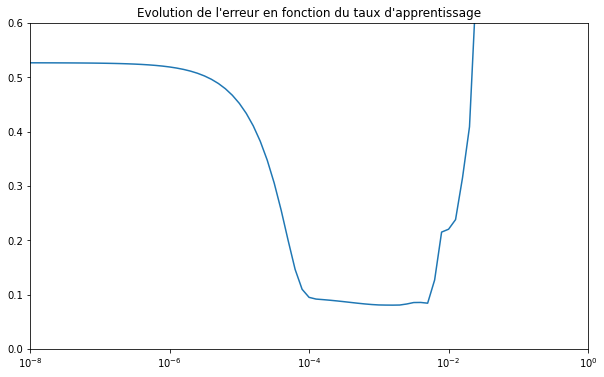

In [19]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ 1e-8, 1, 0, 0.6])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [40]:
# Chargement des poids sauvegardés
model.load_weights("poids_opti.hdf5")

In [16]:
# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.01)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=500,verbose=1, callbacks=[CheckPoint,StopTrain(delta=3e-5,periodes = 20, term="loss")])

Epoch 1/500
30/30 [==============================] - 6s 53ms/step - loss: 0.2262 - mae: 0.5346 - val_loss: 0.0850 - val_mae: 0.3150

Epoch 00001: loss improved from inf to 0.14918, saving model to poids_train.hdf5
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 0.0823 - mae: 0.3140 - val_loss: 0.0797 - val_mae: 0.3080

Epoch 00002: loss improved from 0.14918 to 0.08757, saving model to poids_train.hdf5
Epoch 3/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0766 - mae: 0.3008 - val_loss: 0.0783 - val_mae: 0.3056

Epoch 00003: loss improved from 0.08757 to 0.08327, saving model to poids_train.hdf5
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 0.0750 - mae: 0.2980 - val_loss: 0.0775 - val_mae: 0.3042

Epoch 00004: loss improved from 0.08327 to 0.08176, saving model to poids_train.hdf5
Epoch 5/500
30/30 [==============================] - 0s 15ms/step - loss: 0.0743 - mae: 0.2970 - val_loss: 0.0770 - val_mae: 0.3033


Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

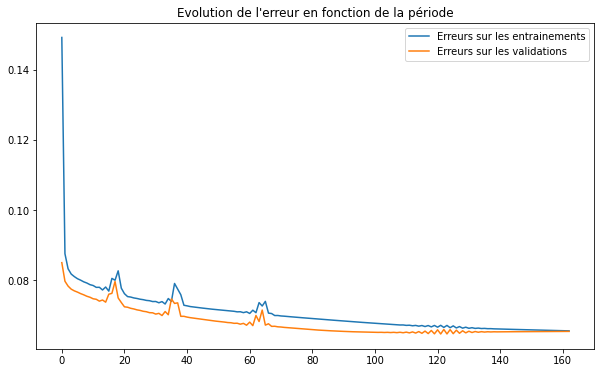

In [17]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**5. Prédiction des données**

In [18]:
x_predictions = np.concatenate((x_entrainement_norm[-taille_fenetre-Nbr_Sequences:],x_validation_norm))
dataPredict = prepare_dataset_XY(x_predictions,taille_fenetre,batch_size,buffer_melange,Nbr_Sequences)
predictions = model.predict(dataPredict)

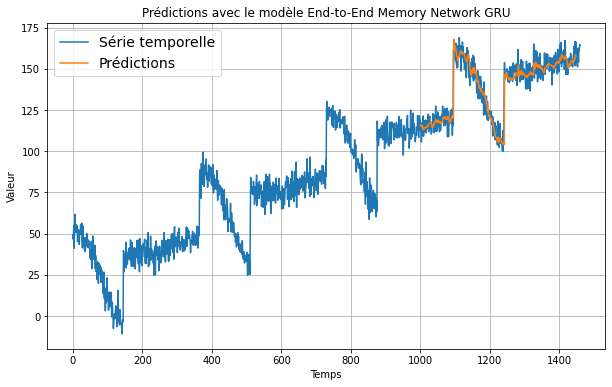

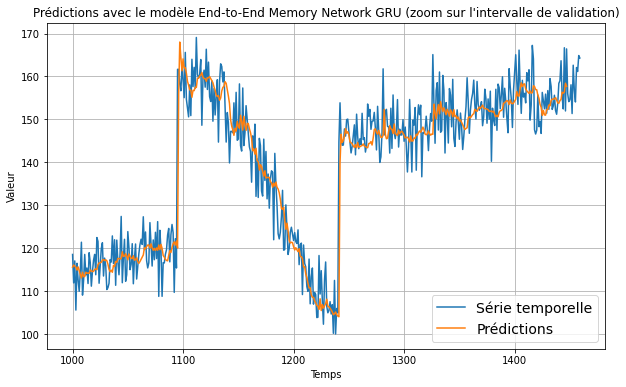

In [19]:
lag = Nbr_Sequences

# Ecart entre la taille des prédictions et la taille de la zone de validation
ecart = len(x_validation)+taille_fenetre+Nbr_Sequences - len(predictions)

# Ce qui n'a pas été pris par la prédiction
reste = ecart - taille_fenetre

preds = np.asarray(predictions*std.numpy()+mean.numpy())[:,0] + trend[temps_separation:-reste+Nbr_Sequences]

# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")

if reste != 0:
  affiche_serie(temps[temps_separation:-reste+Nbr_Sequences],preds,label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],preds,label="Prédictions")


plt.title('Prédictions avec le modèle End-to-End Memory Network GRU')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
if reste != 0:
  affiche_serie(temps[temps_separation:-reste+Nbr_Sequences],preds,label="Prédictions")
else :
  affiche_serie(temps[temps_separation+taille_fenetre:taille_fenetre],preds,label="Prédictions")
plt.title("Prédictions avec le modèle End-to-End Memory Network GRU (zoom sur l'intervalle de validation)")
plt.show()

**6. Analyse des résultats**

In [20]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:-reste+Nbr_Sequences],preds[taille_fenetre:]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:-reste+Nbr_Sequences],preds[taille_fenetre:]).numpy()

print(mae)
print(mse)

4.476343293998931
36.326581589368544


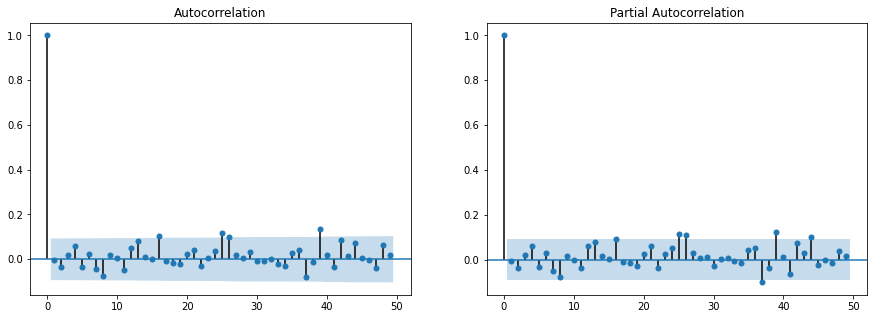

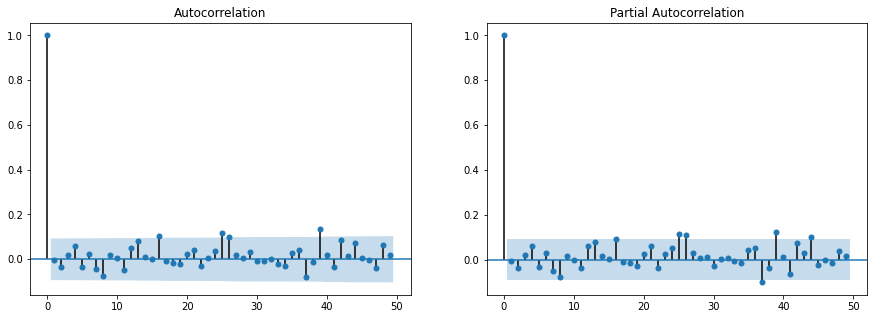

In [21]:
residus = serie[temps_separation+taille_fenetre:-reste+Nbr_Sequences] - preds[taille_fenetre:]

# ACF & PACF de la série Homoscédatique

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(residus, ax=ax1, lags = range(0,50))
plot_pacf(residus, ax=ax2, lags = range(0, 50))